In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Estudio preliminar de los datos

Lo primero que se va a hacer es importar los datos y hacer un breve estudio para ver con qué se va a trabajar

In [2]:
df = pd.read_csv('airbnb.csv')
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


Con el método DataFrame.info() se puede ver si hay valores nulos en alguna columna

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             13321 non-null  object 
 1   neighbourhood                   13321 non-null  object 
 2   latitude                        13321 non-null  float64
 3   longitude                       13321 non-null  float64
 4   room_type                       13321 non-null  object 
 5   price                           13321 non-null  int64  
 6   minimum_nights                  13321 non-null  int64  
 7   number_of_reviews               13321 non-null  int64  
 8   reviews_per_month               13321 non-null  float64
 9   calculated_host_listings_count  13321 non-null  int64  
 10  availability_365                13321 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


Afortunadamente no hay datos nulos así que no hay que realizar limpieza en ese aspecto

Para echar un primer vistazo a las variables numéricas se va a usar DataFrame.describe() que proporciona distintos estadísticos como la media, la mediana etc de cada variable numérica

In [4]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000
mean,40.420730,-3.697268,69.171834,3.010885,22.986037,1.520329,7.605885,205.867202
std,0.020344,0.023832,103.721126,12.835619,38.406006,1.852367,19.619972,126.968961
min,40.331888,-3.863907,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410090,-3.707856,31.000000,1.000000,1.000000,0.110000,1.000000,84.000000
50%,40.418731,-3.701602,53.000000,2.000000,7.000000,0.780000,2.000000,247.000000
75%,40.427997,-3.693818,80.000000,3.000000,28.000000,2.320000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,1125.000000,446.000000,17.210000,145.000000,365.000000


Se observa que las variables price, minimum_nights, number_of_reviews y calculated_host_listings_count tienen una enorme diferencia entre su media y su mediana, lo que indica que son variables muy sesgadas. Cuando a continuación se dibujen sus histogramas se observará una cola por la derecha

Ahora se va a estudiar las variables categóricas haciendo un recuento de cuantas veces aparece cada valor

In [5]:
df["neighbourhood_group"].value_counts()

Centro                   6773
Chamberí                  960
Salamanca                 883
Arganzuela                790
Tetuán                    463
Moncloa - Aravaca         450
Retiro                    439
Latina                    379
Chamartín                 361
Carabanchel               358
Ciudad Lineal             308
Puente de Vallecas        222
Hortaleza                 185
Fuencarral - El Pardo     170
Usera                     145
San Blas - Canillejas     117
Villaverde                 83
Barajas                    81
Moratalaz                  74
Villa de Vallecas          46
Vicálvaro                  34
Name: neighbourhood_group, dtype: int64

In [6]:
df["neighbourhood"].value_counts()

Embajadores       1848
Universidad       1363
Palacio           1084
Sol                942
Justicia           788
                  ... 
Rosas                4
Pavones              4
Cuatro Vientos       3
Orcasitas            2
El Pardo             1
Name: neighbourhood, Length: 126, dtype: int64

In [7]:
df["room_type"].value_counts()

Entire home/apt    7926
Private room       5203
Shared room         192
Name: room_type, dtype: int64

En la variable room_type hay un gran desequilibrio entre sus categorías: la categoría Shared room es mucho menos frecuente que las otras dos. Este se tendrá en cuenta al hacer la separación en test y training set y al diseñar los modelos.

Por otro lado, la variable neighbourhood tiene muchas categorías que aparecen muy pocas veces. Esto puede causar que al dividir en training y test set algunas categorías solo aparezcan en el test set. Además al ser tan infrecuentes es improbable que el modelo aprenda nada de ellas. Por lo tanto las que aparecen menos de 10 veces se van a agrupar en la categoría 'Otros'

In [8]:
frecuencias = pd.DataFrame(df["neighbourhood"].value_counts())
df = df.join(frecuencias, on = 'neighbourhood',how = 'right', rsuffix='_frequencies')
df.loc[df['neighbourhood_frequencies'] < 10, 'neighbourhood'] = 'Otro'
df.drop(columns=['neighbourhood_frequencies'],inplace=True)
df.sort_index(inplace=True)

In [9]:
df["neighbourhood"].value_counts()

Embajadores    1848
Universidad    1363
Palacio        1084
Sol             942
Justicia        788
               ... 
Salvador         13
Marroquina       12
Ambroz           12
Piovera          12
Palomas          12
Name: neighbourhood, Length: 108, dtype: int64

Se dibujan histogramas de las variables numéricas

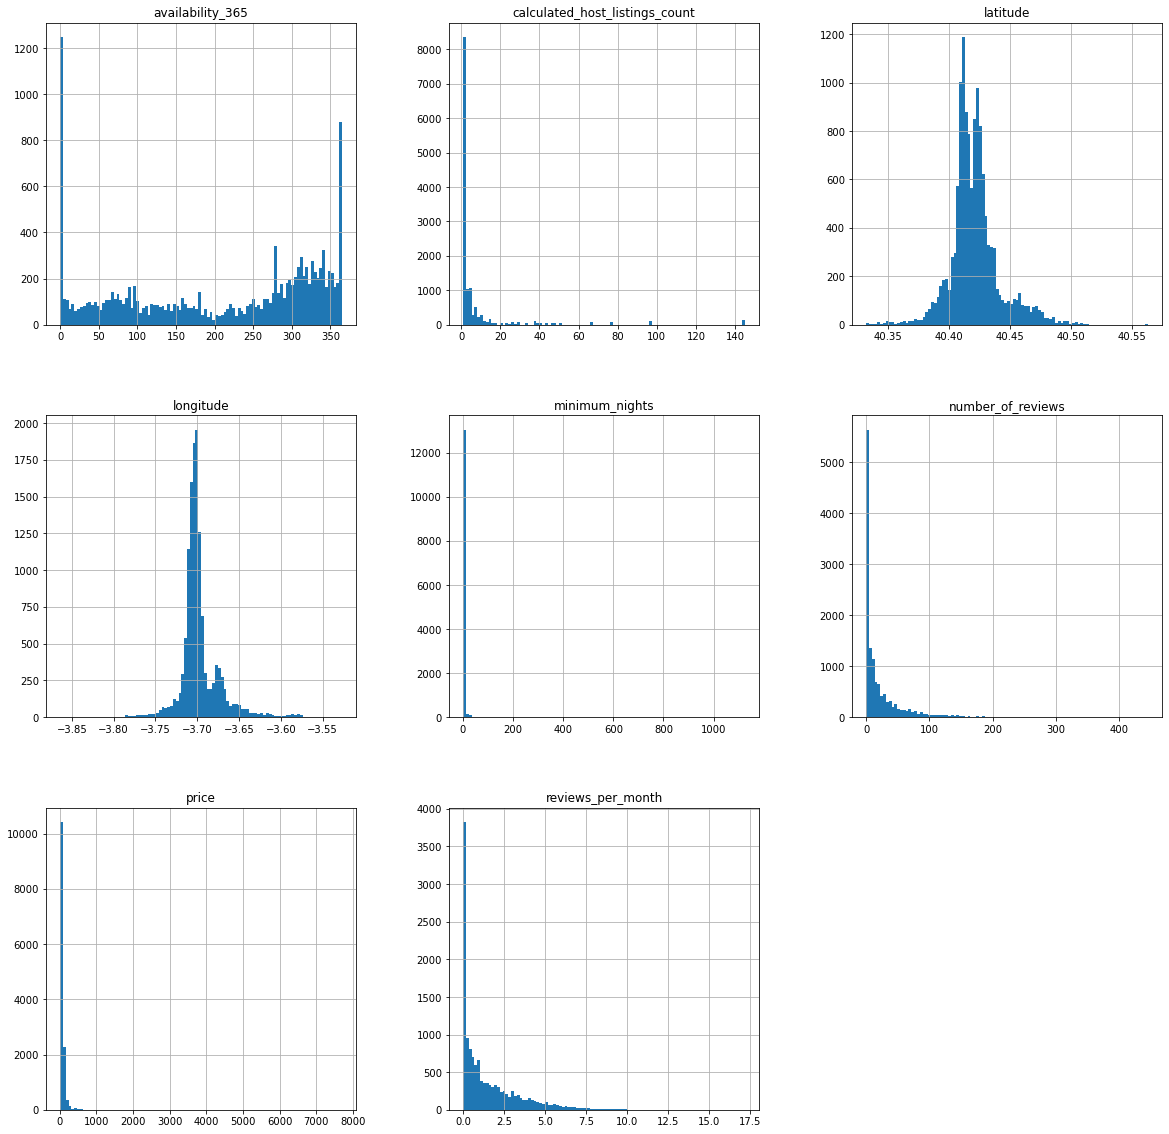

In [10]:
df.hist(bins=100,figsize=(20,20))
plt.show()

Como se esperaba, las variables price, minimum_nights, number_of_reviews y calculated_host_listings_count tienen su máximo muy a la izquierda y una cola por la derecha. Como los máximos son tan grandes hay valores que no se aprecian bien, así que a continuación se dibujan los mismos histogramas pero en escala logarítmica para que aprecien bien todos los valores

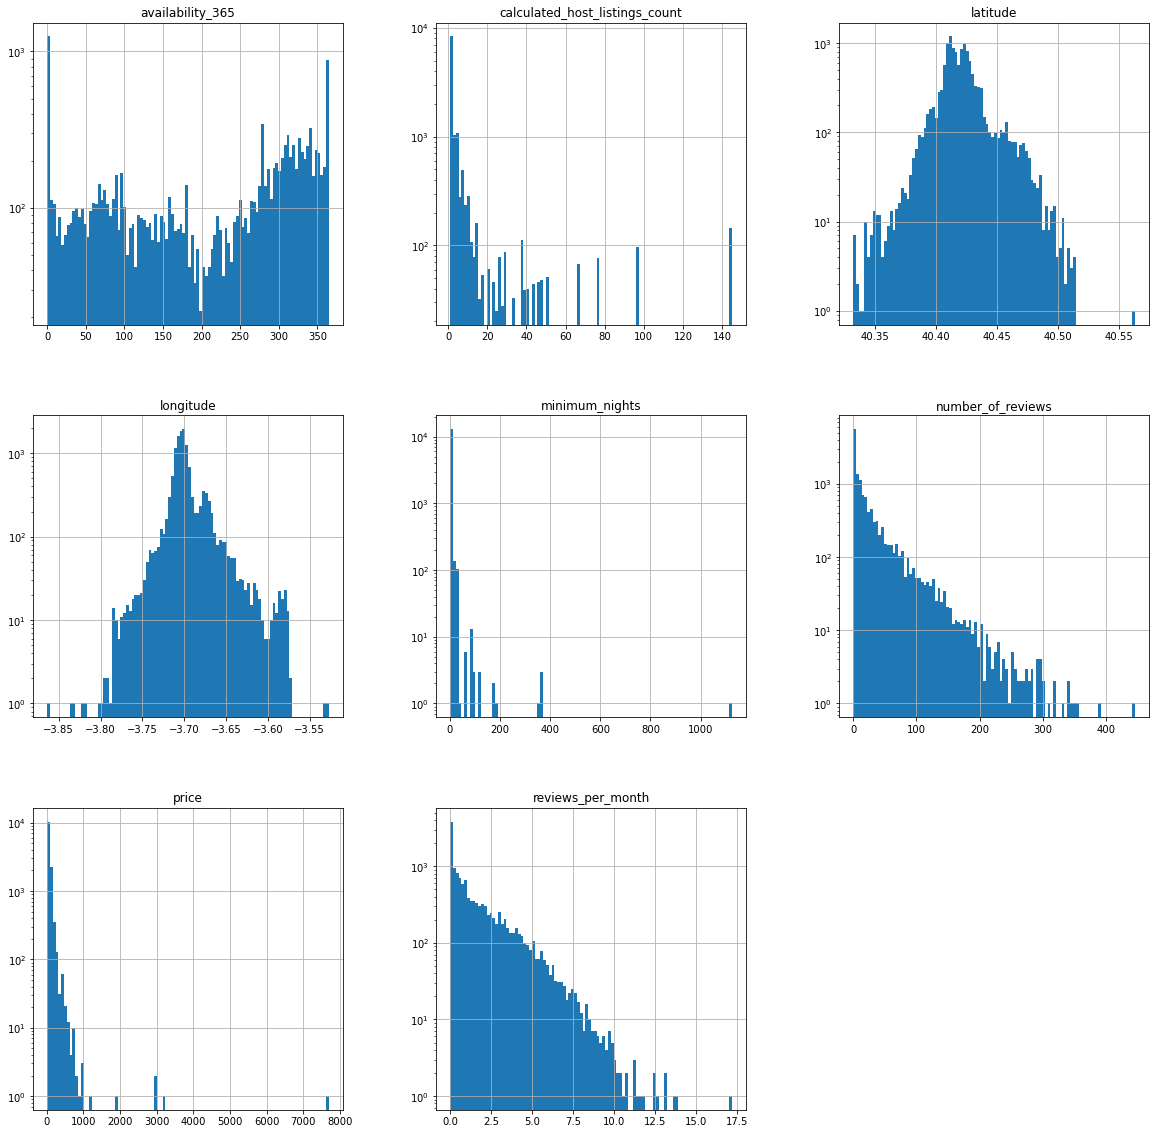

In [11]:
df.hist(bins=100,figsize=(20,20), log = True)
plt.show()

# Separación en training set y test set

Como la variable objetivo está tan desequilibrada, se va a usar StratifiedShuffleSplit para que la proporción entre las tres categorías de room_type se mantenga en ambos sets. 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in split.split(df, df['room_type']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

A continuación se comprueba que la proporción entre las categorías en el test set es aproximadamente igual que en el dataframe original

In [13]:
test_set["room_type"].value_counts()/df["room_type"].value_counts()

Entire home/apt    0.200101
Private room       0.200077
Shared room        0.197917
Name: room_type, dtype: float64

# Preparación datos

La preparación de los datos va a consistir en solo dos transformaciones. A las variables numéricas se les va a aplicar MinMaxScaler de manera que sus valores queden entre 0 y 1. A las variables categóricas se les aplica OneHotEncoder de manera que haya una columna con 1 o 0 para cada categoría. Estas transformaciones se realizan solo sobre las variables independientes, la variable independiente (room_type) queda intacta.

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

train_set_features = train_set.drop(columns=['room_type'])
train_set_labels = train_set['room_type'].copy()

num_attribs = ['latitude','longitude',
               'price','minimum_nights',
               'number_of_reviews',
               'reviews_per_month',
               'calculated_host_listings_count',
               'availability_365']
cat_attribs = ['neighbourhood_group', 'neighbourhood']

pipeline = ColumnTransformer([
        ("num", MinMaxScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_set_prepared = pipeline.fit_transform(train_set_features)

Aunque no se pide explicitamente en el enunciado de la práctica, también se realiza la preparación de los datos en el test set para luego poder comprobar la precisión del modelo sobre él.

In [15]:
test_set_features = test_set.drop(columns=['room_type'])
test_set_labels = test_set['room_type'].copy()

test_set_prepared = pipeline.transform(test_set_features)

# Naive Bayes

De entre los disintos modelos Naive Bayes se ha escogido el Complement Naive Bayes ya que según su documentación es el más adecuado para tratar con categorías desequilibradas como es este caso.

In [16]:
from sklearn.naive_bayes import ComplementNB
NB_model = ComplementNB()

En este modelo no hay que ajustar hiperparámetros así que se procede directamente a hacer la validación cruzada.

In [17]:
scores = cross_val_score(NB_model, train_set_prepared, train_set_labels,
                         scoring="accuracy", cv=10)
scores.mean()

0.6440512996679263

Para medir la precisión del modelo sobre el test set se ha creado una función que comparará las categorías predichas con las reales.

In [18]:
def accuracy(list1, list2):
    bool_list = (list1 == list2)
    return np.count_nonzero(bool_list == True)/len(bool_list)

In [19]:
NB_model.fit(train_set_prepared, train_set_labels)
predictions = NB_model.predict(test_set_prepared)

In [20]:
accuracy(predictions, test_set_labels.values)

0.6472795497185742

La accuracy del modelo es ligeramente mayor en el test set, cuando debería ser menor. De todas formas la diferencia es tan pequeña que probablemente se deba a que la precisión en el training set se está calculando como la media de todas las validaciones cruzadas.

# KNN

Para el modelo de k-nearest neighbors se ha elegido la opción de que cada vecino tenga un peso inversamente proporcional a su distancia (weights = 'distance'). De esta manera la cercanía de un vecino hace que tenga mayor peso lo que ayudaría con el desequilibrio de la variable room_type.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(weights = 'distance')

Primero se calcula la precisión con validación cruzada sin ajustar los hiperparámetros

In [22]:
scores = cross_val_score(knn, train_set_prepared, train_set_labels, scoring="accuracy", cv=10)
scores.mean()

0.7088923534955827

En este modelo el único hiperparámetro que hay que ajustar es el número de vecinos k. Como a priori no se conoce en qué rango de valores puede estar el k óptimo, primero se hace una busqueda entre valores de distintos tamaños.

In [23]:
param_grid = [
    {'n_neighbors': [1,5,10,50,100,500,1000,5000]}]


grid_search = GridSearchCV(knn, param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

{'n_neighbors': 5}

Ahora que se sabe en qué rango de valores está el k óptimo se puede hacer una búsqueda más detallada entre todos los valores entre 1 y 10, omitiendo los múltiplos de 3 para que no haya empates.

In [24]:
param_grid = [
    {'n_neighbors': [2,4,5,7,8]}]


grid_search = GridSearchCV(knn, param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

{'n_neighbors': 8}

Ahora que se ha determinado que el k óptimo es 8 se usa para hacer la validación cruzada

In [25]:
knn = KNeighborsClassifier(n_neighbors = 8, weights = 'distance')
scores = cross_val_score(knn, train_set_prepared, train_set_labels, scoring="accuracy", cv=10)
scores.mean()

0.709550511323098

La precisión es ligeramente mayor que con los valores por defecto

Finalmente se calcula la precisión del modelo con el test set

In [26]:
knn.fit(train_set_prepared, train_set_labels)
predictions = knn.predict(test_set_prepared)
accuracy(predictions, test_set_labels.values)

0.7110694183864915

En este caso la accuracy en el test set es de nuevo ligeramente mayor que en el training set porque en este se calcula como la media de todas las validaciones cruzadas

# Decision Tree 

En el modelo de Decision Tree para tratar con con el desequilibrio de la variable room_type se ha elegido la opción class_weight = 'balanced' para que cada punto tenga un peso inversamente proporcional a la frecuencia de su categoría

In [27]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(class_weight = 'balanced')

Primero se prueba la validación cruzada sin ajustar hiperparámetros

In [28]:
scores = cross_val_score(tree_clf, train_set_prepared, train_set_labels,
                         scoring="accuracy", cv=10)
scores.mean()

0.8583899268028434

Para que no haya que evaluar cada posible combinación de max_leaf_nodes, min_samples_split y max_depth primero se hace una busqueda preliminar y en función de lo que se obtenga se hará otra busqueda más exhaustiva

In [29]:
param_grid = [
    {'max_leaf_nodes': range(2,51,4),
    'min_samples_split': range(2,7,2),
    'max_depth': range(1,21,3)}]


grid_search = GridSearchCV(tree_clf, param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

{'max_depth': 7, 'max_leaf_nodes': 14, 'min_samples_split': 2}

Ahora sabiendo en qué rango se encuentran los valores óptimos de los hiperparámetros se realiza una búsqueda más precisa.

In [30]:
param_grid = [
    {'max_leaf_nodes': [11,12,13,14,15,16,17],
    'min_samples_split': [2,3],
    'max_depth': [5,6,7,8,9]}]


grid_search = GridSearchCV(tree_clf, param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

grid_search.fit(train_set_prepared, train_set_labels)
grid_search.best_params_

{'max_depth': 6, 'max_leaf_nodes': 14, 'min_samples_split': 2}

Una vez encontrados los hiperparámetros óptimos se usan en la validación cruzada

In [31]:
tree_clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 6, max_leaf_nodes = 14, min_samples_split = 2)

scores = cross_val_score(tree_clf, train_set_prepared, train_set_labels,
                         scoring="accuracy", cv=10)
scores.mean()

0.8253595116666226

A priori parace sorprendente que la precisión ahora sea menor que cuando se ha usado el modelo con las opciones por defecto. El motivo es que por defecto max_depth y max_leaf_nodes son ilimitados lo que provoca que haya mucho overfitting y la precisión sea mayor.

Por último se prueba el modelo con el test set.

In [32]:
tree_clf.fit(train_set_prepared, train_set_labels)
predictions = tree_clf.predict(test_set_prepared)
accuracy(predictions, test_set_labels.values)

0.8375234521575985

La precisión para el test set es un poco mejor que para el training set, por los mismos motivos que en los otros dos modelos

# Conclusiones

De los tres modelos el que consigue hacer predicciones con mayor exactitud es el Decision Tree (83%), con una gran diferencia con respecto a los otros dos (65% y 71%). Cabe destacar que una exactitud del 83% es batante buena teniendo en cuenta que el tamaño del data set no era muy grande, las clases estaban desequilibradas y que los datos se han usado prácticamente sin modificar. Es decir, que si se hubiera contado con un experto que supiera como se relacionan las variables independientes con la dependiente se podrían haber hecho modelos más exactos.

Es notable también que ajustar los hiperparámetros no ha resultado en una gran mejoría de la exactitud.